# Investigating the Boston House Prices Dataset

## Table of Contents <a class="ancor" id="contents"/>

1. [Introduction](#intro)
1. [Summary Statistics](#summary-stats)
1. [Visualising the Data](#plots)
    1. [Distribution of Price](#distPrice)
    1. [Correlation](#corr)
    1. [Scatter Plots of Relationships ](#scatter)
        <br>- [Stronger Predictors](#stronger)
        <br>- [Weaker Predictors](#weaker)
1. [CHAS Variable](#chas)
    1. [Distribution of Tip Rate](#tiprate)
    1. [Table Size, Day and Time of Day](#dayTime)
1. [Regression](#regression)
1. [Findings](#findings)

## Introduction <a class="ancor" id="intro"/>

Getting Started
In this project, I will be looking at the well known Boston House Prices Dataset. It will include a look into the data and some general statistics, and then we will be attempting to use keras to create a neural network
that can predict the median house price based on the other variables in the dataset In this dataset information was collected from homes in suburbs of Boston, Massachusetts. This model could be very helpful for someone like a real estate agent city planners who could make use of such information on a daily basis.

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.[5]

## Summary Statistics <a class="ancor" id="summary-stats"/>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.stats.weightstats as ws

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

Next load data from scikit-learn library and have a look at data

In [5]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


These are essentially keys to a dictionary

- data: info for different houses
- target: prices for different houses
- feature_names: names of the features
- DESCR: describes the dataset

In [6]:
print(boston.data.shape)

(506, 13)


Check for its shape by calling the boston.data.shape and it will return the size of the dataset with the column size.
This means there are 506 rows of data with 13 columns.

In [7]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


These are the column names but they don't make too much sense we need some more information

In [8]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

So as we can see there are quite a few variables listed that could have an effect on house prices such as crime rate, number of rooms, pupil teacher ratio. There are a few that may not quite affect house prices so we may eliminate these initally so make things a bit more understandable.
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- AGE      proportion of owner-occupied units built prior to 1940
***
So now we know a little more about this lets have a look using pandas at the actual data. To do this we have to convert it to dataframe and use head() to have a look

In [9]:
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
#df = df.drop("ZN", 1)
#df = df.drop("INDUS", 1)
#df = df.drop("AGE", 1)
# need to add column names otherwise we just get index numbers which aren't very helpful alone
display(df.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There seems to be no column called price in the dataframe. The target column is available in another attribute called target as we saw above when we looked at our keys. This is an important variable as later we will be trying to predict this. Our target is MEDV which is the median house value in 1000's of dollars.

In [10]:
print(boston.target.shape)
# rows see above data keys

(506,)


This number matches our datasets number of rows as we saw above so we can add it to our dataframe

In [11]:
# changed medv to price for readablity
df['PRICE'] = boston['target']
# used display to make nice table [1]
display(df.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [12]:
# moved price to front of df for ease
# dummy var to hold copy of proce column
y = df['PRICE'].copy()
# delete it from frame
del df['PRICE']
# concentate to combine it with reaining df along 1st axis [2]
df = pd.concat((y, df), axis=1)


In [13]:
df.head()

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [14]:
df.tail()
# zn and chas have alot of 0s - categorical

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
501,22.4,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,20.6,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,23.9,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,22.0,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48
505,11.9,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88


In [15]:
df.isnull().sum()
#checking for any missing data 
#which Pandas automatically sets as NaN values.we can see these by using df.isnull() , 
#and then the number of NaN's per column is df.isnull().sum()

PRICE      0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [16]:
#replaced all the 0s with nan [4]
#df.replace(0, np.nan, inplace=True)
#df.info()

In [17]:
#getting percentage will disregard zn and chas
#df.isnull().sum()/len(df)*100

In [18]:
#df = df.drop("ZN", 1)
#df = df.drop("CHAS", 1) # charles river variable will need later!

In [19]:
len(df)

506

In [20]:
df.dtypes

PRICE      float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

All data are floats, which means this is most likely a continuous variable, including the target. This means that predicting the target variable is a regression problem. [3]

In [21]:
display(df.describe().T)
# transposed data to make it easier to read

,count,mean,std,min,25%,50%,75%,max
PRICE,506.0,22.532806,9.197104,5.00000,17.025000,21.20000,25.000000,50.0000
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000


We have data from 506 neighborhoods/townships in the Boston area. Summary of some tendencies and distribution of some key features:

- The average per capita crime rate is 3.61%
- The average number of rooms per dwelling is 6.28, but ranges from 3.5 to 8.7.
- The average nitric oxide concentration (in parts per 10 million) is .55. The neighborhood with the least NOX has .38, the one with the most has .87.
- The average Pupil-Teacher ratio is 18 students to one teacher.
- The average weighted distance to the five major Boston employment centers is 3.79.
- The average percent of lower status population is 12.65%, but ranges from 1.73% to a more impoverished 37.97%

In terms of price:
- The average price house was 22.532806	or \\$22,533
- The highest price was 50.0000 or \\$50,000
- The lowest price was 5.00000 or \\$5,000
- The standard deviation is 9.197104, which means our price values are quite widely spread

In [22]:
pricetotal = df.sort_values("PRICE", ascending = False)
pricetotal.head(20)

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
283,50.0,0.01501,90.0,1.21,1.0,0.4010,7.923,24.8,5.8850,1.0,198.0,13.6,395.52,3.16
225,50.0,0.52693,0.0,6.20,0.0,0.5040,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63
369,50.0,5.66998,0.0,18.10,1.0,0.6310,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73
370,50.0,6.53876,0.0,18.10,1.0,0.6310,7.016,97.5,1.2024,24.0,666.0,20.2,392.05,2.96
371,50.0,9.23230,0.0,18.10,0.0,0.6310,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53
372,50.0,8.26725,0.0,18.10,1.0,0.6680,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88
186,50.0,0.05602,0.0,2.46,0.0,0.4880,7.831,53.6,3.1992,3.0,193.0,17.8,392.63,4.45
204,50.0,0.02009,95.0,2.68,0.0,0.4161,8.034,31.9,5.1180,4.0,224.0,14.7,390.55,2.88
257,50.0,0.61154,20.0,3.97,0.0,0.6470,8.704,86.9,1.8010,5.0,264.0,13.0,389.70,5.12
195,50.0,0.01381,80.0,0.46,0.0,0.4220,7.875,32.0,5.6484,4.0,255.0,14.4,394.23,2.97


Looking at the 20 highest priced homes, generally the crime rate seems to be lower. The houses mostly have more rooms, which makes sense as this would be a general trend from most houses. It also appears that the these homes tend to be in more affluent areas as the lsat of these homes is quite low. These homes also seem generally to be not beside the Charles River.

In [88]:
df[(df['AGE']>=95.0)].describe()

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,17.471681,9.102899,0.575221,17.778407,0.061947,0.663956,5.940398,98.222124,2.017613,15.132743,540.486726,19.153097,333.550177,19.131770
std,9.793169,12.444375,3.098258,4.656246,0.242133,0.093453,0.707281,1.699461,0.882386,9.836616,157.596689,2.340523,107.242503,7.703658
min,5.000000,0.098490,0.000000,2.460000,0.000000,0.448000,3.863000,95.000000,1.137000,2.000000,188.000000,13.000000,2.600000,1.920000
25%,12.300000,1.192940,0.000000,18.100000,0.000000,0.605000,5.520000,96.800000,1.527500,5.000000,403.000000,19.100000,330.040000,15.020000
50%,15.000000,5.872050,0.000000,18.100000,0.000000,0.659000,6.006000,98.300000,1.812500,24.000000,666.000000,20.200000,380.790000,18.850000
75%,19.100000,11.951100,0.000000,19.580000,0.000000,0.700000,6.402000,100.000000,2.118500,24.000000,666.000000,20.200000,396.900000,24.080000
max,50.000000,73.534100,20.000000,27.740000,1.000000,0.871000,7.929000,100.000000,6.082100,24.000000,711.000000,21.200000,396.900000,37.970000


Here we are looking at the older houses in the dataset, these houses are falling below the average, with an average price of \\$17,472. This is to be expected as you would expect an older house to cost less.

In [93]:
df[(df['INDUS']>=15.0)].describe()

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,17.706771,9.157806,0.437500,19.105833,0.078125,0.672026,6.021161,90.736458,2.036530,17.833333,584.572917,19.344792,307.182135,17.739271
std,8.997196,12.069641,3.481627,2.263625,0.269070,0.086411,0.702431,12.360731,0.581004,9.185883,138.590794,2.049894,130.480605,7.211651
min,5.000000,0.028750,0.000000,15.040000,0.000000,0.464000,3.561000,28.900000,1.129600,2.000000,188.000000,14.700000,0.320000,1.730000
25%,12.700000,2.310525,0.000000,18.100000,0.000000,0.605000,5.690500,87.975000,1.612875,5.000000,437.000000,20.200000,292.105000,13.317500
50%,15.900000,5.776155,0.000000,18.100000,0.000000,0.671000,6.107500,95.250000,1.931050,24.000000,666.000000,20.200000,375.005000,17.155000
75%,20.600000,11.121175,0.000000,19.580000,0.000000,0.713000,6.402500,98.425000,2.307925,24.000000,666.000000,20.200000,395.017500,22.267500
max,50.000000,88.976200,28.000000,27.740000,1.000000,0.871000,8.780000,100.000000,4.098300,24.000000,711.000000,21.200000,396.900000,37.970000


As expected homes that that have more non-retail business acres per town have a lower mean house price of \\$17,707.

## Visualising the Data <a class="ancor" id="plots"/>
### Distribution of Price <a class="ancor" id="distPrice"/>

C:\Users\Zoe\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distrubution of Price')

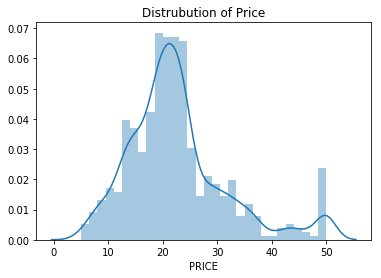

In [23]:
sns.distplot(df["PRICE"], bins=30)
plt.title("Distrubution of Price")

We see that the values of price are distributed normally with few outliers. There are a lot of values at the 50 point, perhaps the data is capped at 50 ie if a house was priced over 50 then it was just entered at that number.

### Correlations <a class="ancor" id="corr"/>

In [24]:
correlation = df.corr().round(2)
display(correlation)

,PRICE,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
PRICE,1.00,-0.39,0.36,-0.48,0.18,-0.43,0.70,-0.38,0.25,-0.38,-0.47,-0.51,0.33,-0.74
CRIM,-0.39,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46
ZN,0.36,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41
INDUS,-0.48,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60
CHAS,0.18,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05
NOX,-0.43,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59
RM,0.70,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61
AGE,-0.38,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60
DIS,0.25,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50
RAD,-0.38,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49


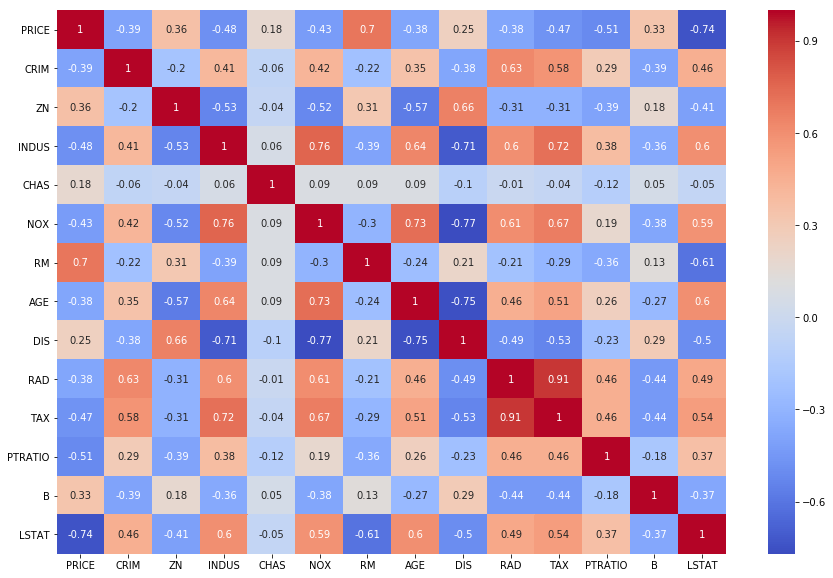

In [25]:
#cor=df.corr()
plt.figure(figsize=(15,10))
#plot the heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Looking at our correlations, RM and LSTAT seem to be the biggest predictors of price. Median value of owner-occupied homes (in 1000$) increases as average number of rooms per dwelling increases and it decreases if percent of lower status population in the area increases. This mirrors the trend noticed earlier in the top 20 priced houses from earlier. PTRATIO, TAX, NOX, INDUS and CRIM are also appearing as weaker but still possible predictors. CHAS does not seem to be a predictor of PRICE.

Other things of note are:
- nox or nitrogen oxides concentration (ppm) increases with increase in proportion of non-retail business acres per town and proportion of owner-occupied units built prior to 1940.
- rad and tax have a strong positive correlation of 0.91 which implies that as accessibility of radial highways increases, the full value property-tax rate per $10,000 also increases.
- crim is strongly associated with variables rad and tax which implies as accessibility to radial highways increases, per capita crime rate increases.
- indus has strong positive correlation with nox, which supports the notion that nitrogen oxides concentration is high in industrial areas.

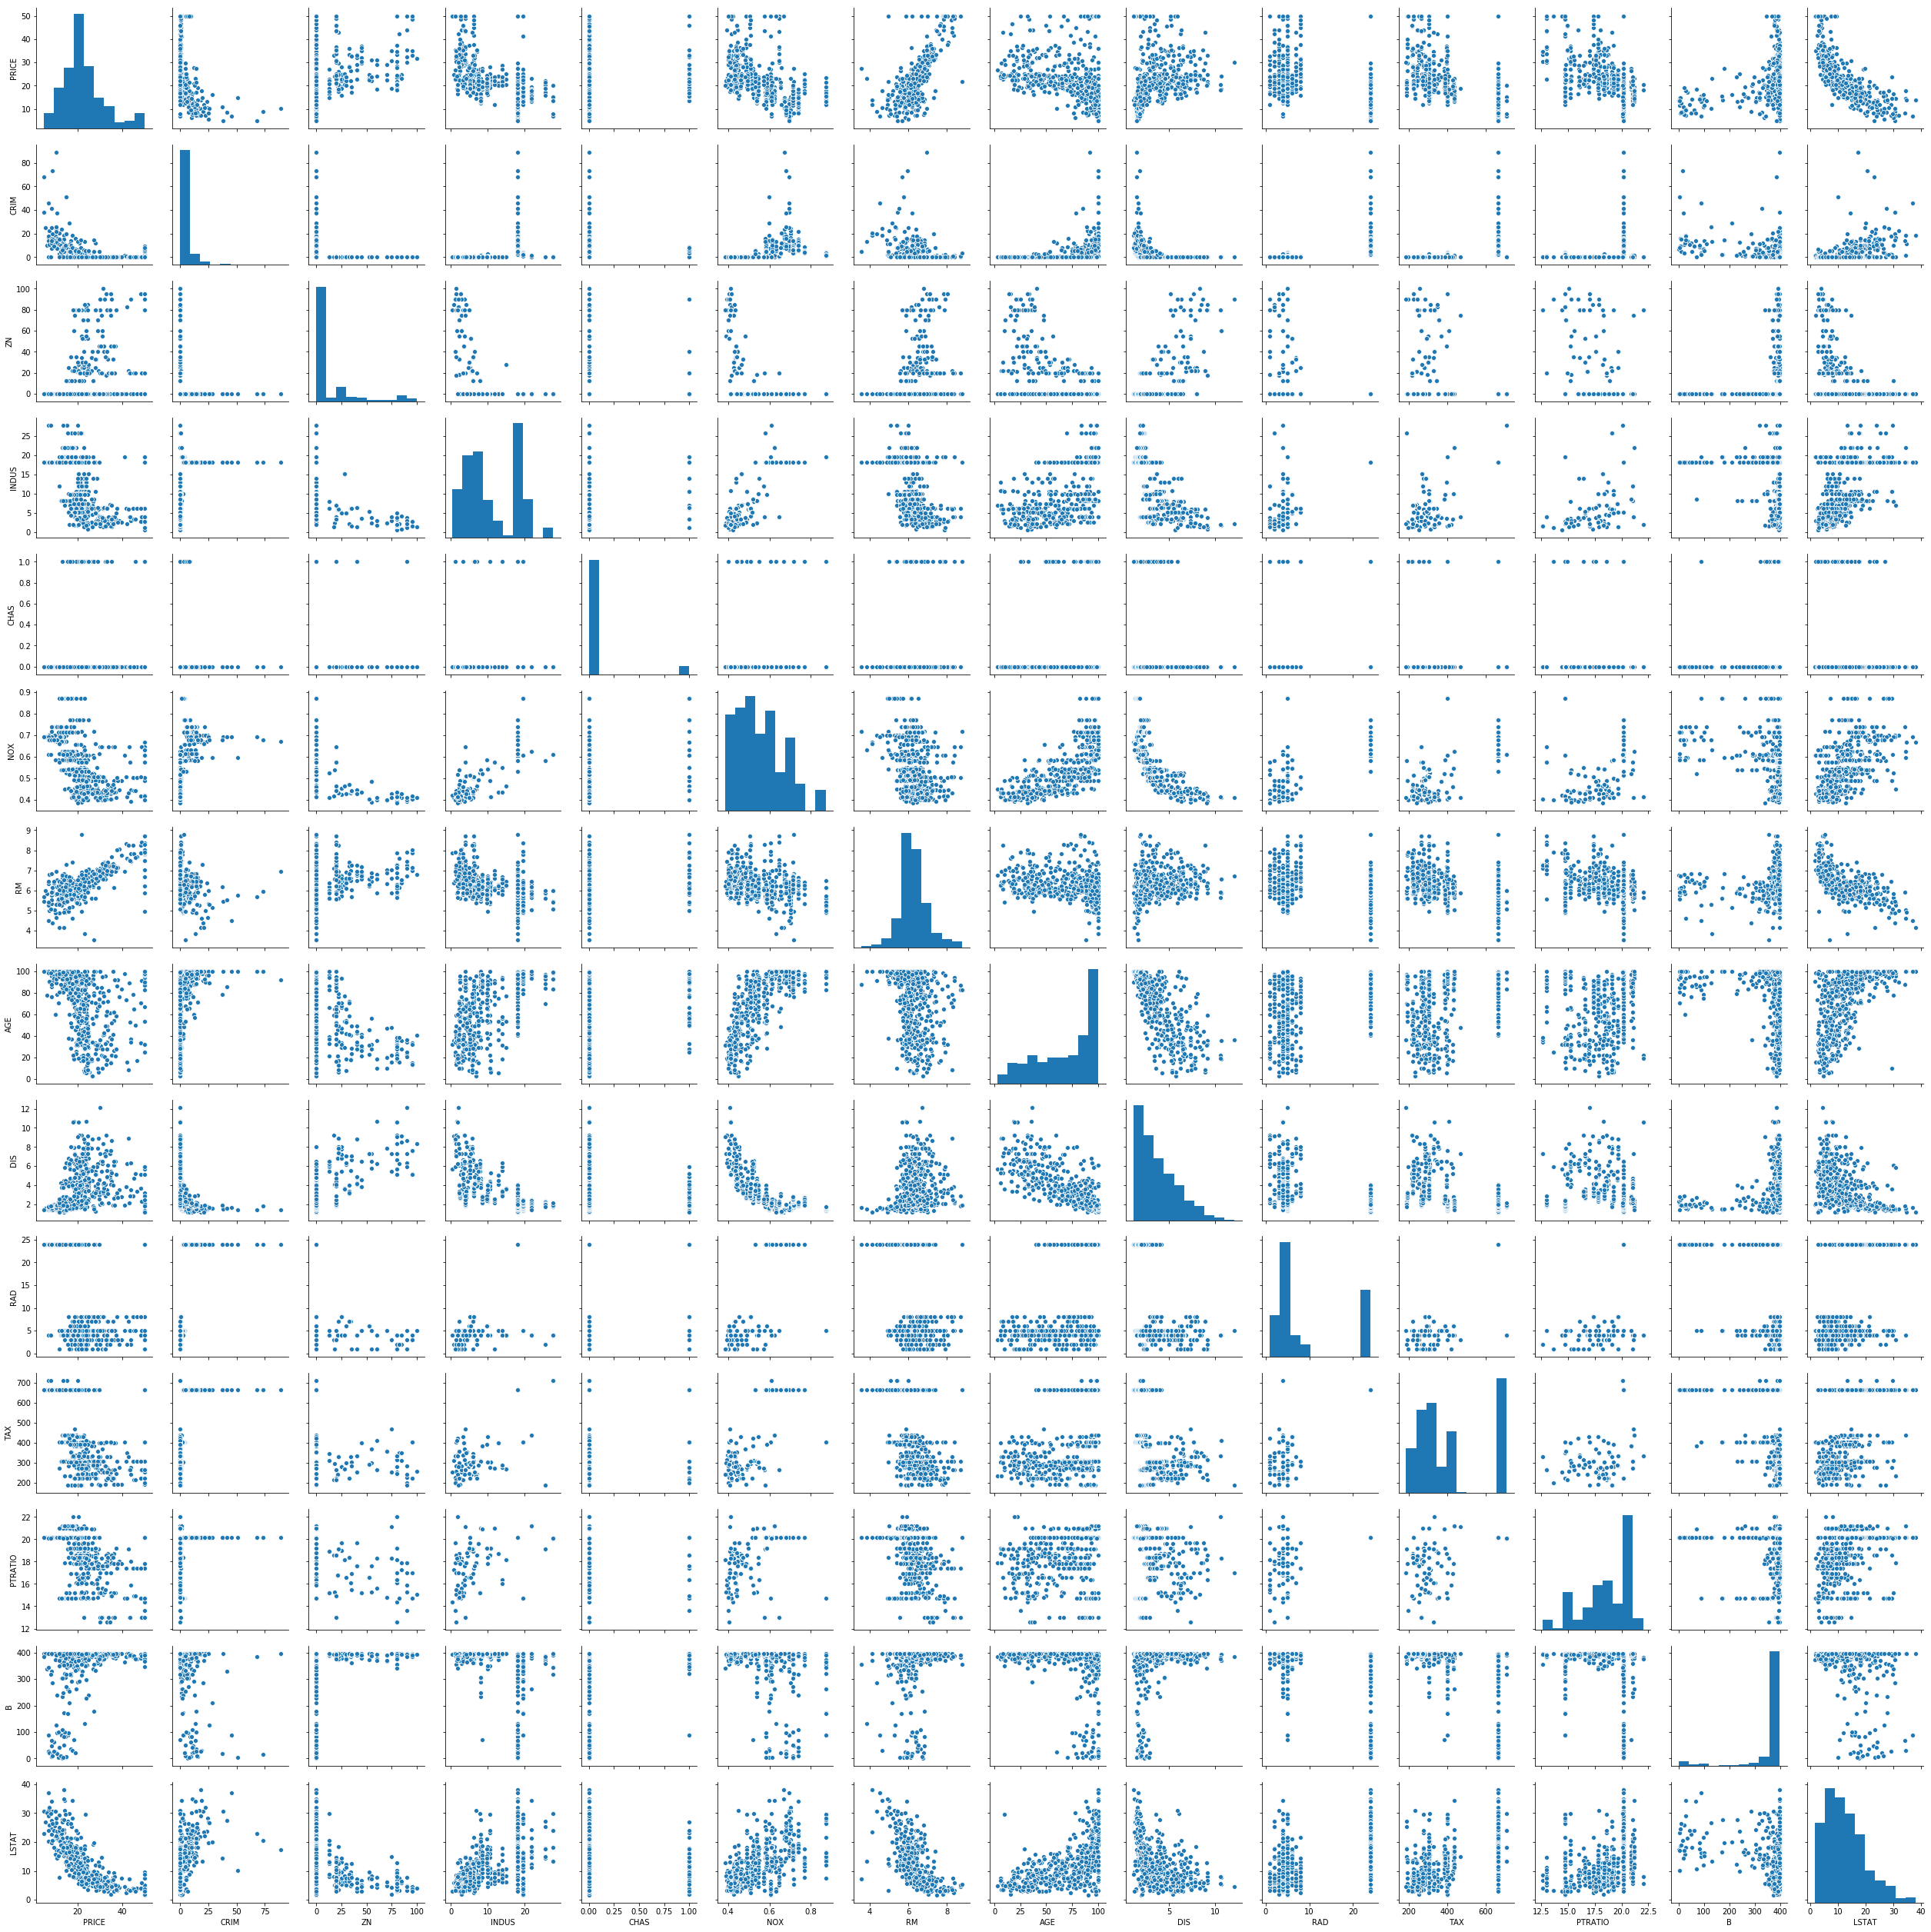

In [26]:
sns.pairplot(df)

- The Proportion of owner occupied units built prior to 1940 (AGE) and proportion of black people by town (B) is heavily skewed to right
- Crime rate (CRIM) and weighted mean of distances to five Boston employment centres (DIS) is heavily skewed to left. 
- RM is normally distributed with mean of approximately 6.
- Most of the properties are situated close to the employment centres (DIS skewed to left) 
- There is a high proportion of owner occupied units built prior to 1940 (age skewed to right) and black people in town (black skewed to right) 
- From scatter plots, it is seen that LSTAT and RM show strong correlation with PRICE. 
- 93% of the properties are away from Charles river. The properties bordering the river seems to have higher median prices.

### Scatter Plots of Relationships <a class="ancor" id="scatter"/>
#### Stronger Predictors <a class="ancor" id="strong"/>

Stronger predictors will have small, tight distributions of data around the line of best fit estimated by the plot.

Text(0.5, 1.0, 'Relationship between RM and Price')

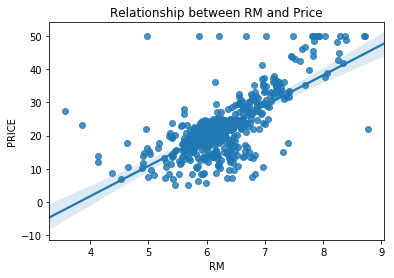

In [27]:
sns.regplot(y="PRICE", x="RM", data=df, fit_reg = True)
plt.title("Relationship between RM and Price")

The number of rooms looks to have strong positive correlation - the prices increase as the value of RM increases linearly. This makes sense as we mentioned earlier, the more rooms a home has, the higher the price will be. There are few outliers and the data seems to be capped at 50 as observed earlier.

Text(0.5, 1.0, 'Relationship between LSTAT and Price')

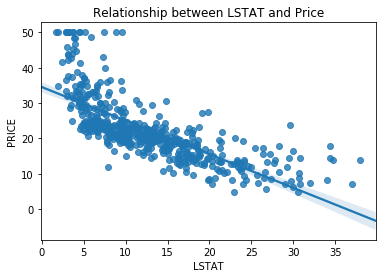

In [28]:
sns.regplot(y="PRICE", x="LSTAT", data=df, fit_reg = True)
plt.title("Relationship between LSTAT and Price")

The percentage of lower status population seems to have a strong negative correlation. The prices tend to decrease with an increase in lower status individuals. The is a trend we noticed earlier in the statistics, and it would be a reasonable expectation that the lower economic status of the area, the lower the house price.  However it it does not look to be following an exactly linear line.

Text(0.5, 1.0, 'Relationship between NOX and Price')

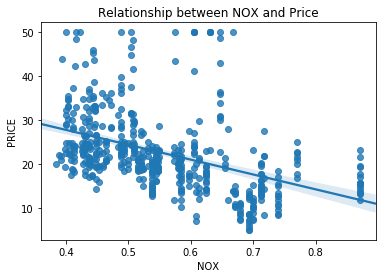

In [29]:
sns.regplot(y="PRICE", x="NOX", data=df, fit_reg = True)
plt.title("Relationship between NOX and Price")

The Nitrus Oxide Concentration (in parts per 10 million) has strong negative coorelation - prices seems to decrease the more pollution there is. Again this makes sense and is in line with what would be expected to be a factor in house prices.

Text(0.5, 1.0, 'Relationship between DIS and Price')

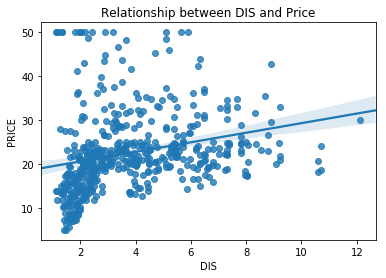

In [30]:
sns.regplot(y="PRICE", x="DIS", data=df, fit_reg = True)
plt.title("Relationship between DIS and Price")

The Weighted Distance from 5 Major Employment Center - there is a strong positive correlation. The closer the burrogh is to employment centers, the higher the housing price.

#### Weaker Predictors <a class="ancor" id="weaker"/>

Text(0.5, 1.0, 'Relationship between PTRATIO and Price')

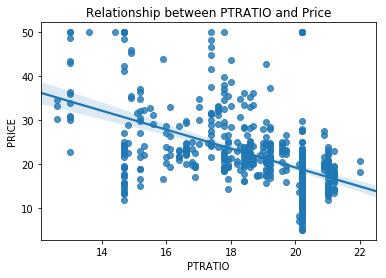

In [31]:
sns.regplot(y="PRICE", x="PTRATIO", data=df, fit_reg = True)
plt.title("Relationship between PTRATIO and Price")

The Pupil Teacher Ratio - as the number of students increases for every teacher, the value of housing decreases.

Text(0.5, 1.0, 'Relationship between Crime Rate and Price')

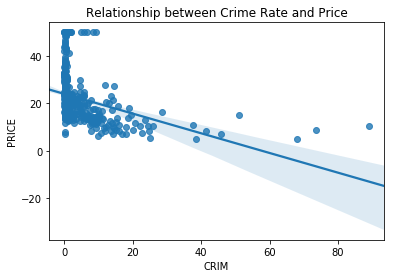

In [32]:
sns.regplot(y="PRICE", x="CRIM", data=df, fit_reg = True)
plt.title("Relationship between Crime Rate and Price")

As the crime rate decreases/increases, the housing price increases/decreases. However the data is very heavily skewed.

## CHAS variable <a class="ancor" id="chas"/>

In the dataset, there is a variable named CHAS that track whether a house is beside the Charles River or not. An input of 1 means that it **is** beside the river, and 0 means that it is **not** beside the River

In [33]:
df.CHAS
df["CHAS"].value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

There are 35 home beside the Charles River and 471 that are not beside the river.

In [34]:
df.pivot(columns='CHAS', values='PRICE').describe()

CHAS,0.0,1.0
count,471.000000,35.000000
mean,22.093843,28.440000
std,8.831362,11.816643
min,5.000000,13.400000
25%,16.600000,21.100000
50%,20.900000,23.300000
75%,24.800000,33.150000
max,50.000000,50.000000


So there is a difference in the average house prices with houses beside the river costing \\$28,440. The average price of a house not beside the river is \\$22,094. The houses beside the river seem to be widely spread throughout the dataset (std of 11.82).

In [35]:
df.pivot(columns='CHAS', values='CRIM').describe()

CHAS,0.0,1.0
count,471.000000,35.000000
mean,3.744447,1.851670
std,8.876818,2.494072
min,0.006320,0.015010
25%,0.079640,0.125060
50%,0.245220,0.447910
75%,3.695030,3.397665
max,88.976200,8.982960


Houses that were beside the river have a lower average crime rate (1.9%) than those that were not beside the river (3.7%).

In [36]:
df.pivot(columns='CHAS', values='LSTAT').describe()

CHAS,0.0,1.0
count,471.000000,35.000000
mean,12.757941,11.241714
std,7.169271,6.686651
min,1.730000,1.920000
25%,7.160000,5.395000
50%,11.380000,10.500000
75%,17.095000,15.070000
max,37.970000,26.820000


There is a small difference in the average percentage of lower status population - 11.2% for those beside the river, and 12.8% for those not beside the river.

In [37]:
print(df.CHAS[df['PRICE']==50.0])
df.CHAS[df['PRICE']==50.0].count()

161    0.0
162    1.0
163    1.0
166    0.0
186    0.0
195    0.0
204    0.0
225    0.0
257    0.0
267    0.0
283    1.0
368    0.0
369    1.0
370    1.0
371    0.0
372    1.0
Name: CHAS, dtype: float64


16

Just over 30% of the \\$50000 are beside the river.

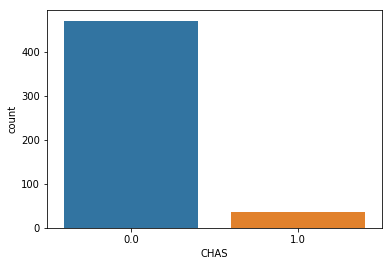

In [38]:
sns.countplot(x='CHAS', data=df)

As we noted earlier, there are a lot more houses not on the river, than are on the river.

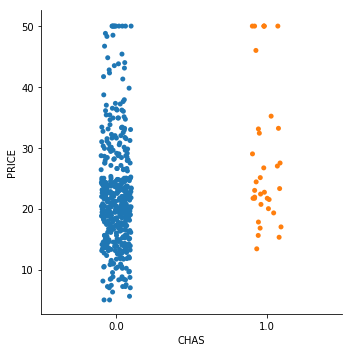

In [39]:
sns.catplot(x='CHAS', y='PRICE', data=df)

The houses along the river is very well distributed through the dataset, however a lot of the 50 and above properties are beside the river as we noted earlier.

Text(0.5, 1.0, 'Price vs Room by River Variable')

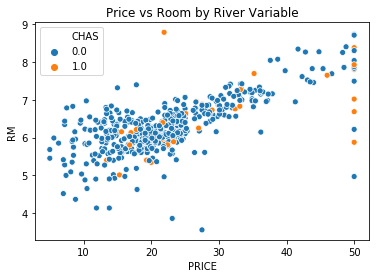

In [40]:
sns.scatterplot(data=df,x='PRICE',y='RM', hue='CHAS')
plt.title("Price vs Room by River Variable")

Text(0.5, 1.0, 'Price vs Socio Economic Status of Area by River Variable')

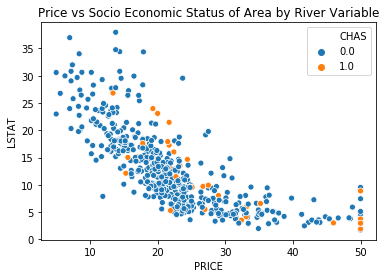

In [41]:
sns.scatterplot(data=df,x='PRICE',y='LSTAT', hue='CHAS')
plt.title("Price vs Socio Economic Status of Area by River Variable")

As we noted in the earlier, there does not seem to be any meaningful relationship between CHAS and PRICE. We would probably need more information or samples to detect any trends in this variable

In [42]:
River = df.loc[df['CHAS'] == 1.0]['PRICE']
NRiver = df.loc[df['CHAS'] == 0.0]['PRICE']

In [43]:
ws.ttest_ind(River, NRiver)

(3.9964374660905095, 7.390623170519883e-05, 504.0)

The t test is a measurement of whether the average (expected) value will differ significantly across the samples provided. A large p-value (greater than 0.05 or 0.1) then we cannot reject the null hypothesis. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages [6].

The t-test gives a very small p-value significantly below 1%, so we we have a clear statistically significant difference and we therefore have to reject the null hypothesis.

In [113]:
# Fitting the model using just 
from statsmodels.formula.api import ols
model = ols("PRICE ~ C(CHAS)", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     15.97
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           7.39e-05
Time:                        19:40:44   Log-Likelihood:                -1832.3
No. Observations:                 506   AIC:                             3669.
Df Residuals:                     504   BIC:                             3677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.0938      0.418     52.902      0.000      21.273      22.914
C(CHAS)[T.1.0]     6.3462      1.588      3.996      0.000       3.226       9.466
==============================================================================
Omnibus:                       81.923   Durbin-Watson:                   0.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.534
Skew:                           1.043   Prob(JB):                     5.50e-28
Kurtosis:                       4.267   Cond. No.                         3.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the results, this model isn't a great fit for our data at all which is to be expected from the above analysis.

The Omnibus/Prob(Omnibus) is a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here. In this case Omnibus quite high (81.923) and the Prob (Omnibus) is quite low (0.000) so the data is not normal.

Skew is a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal. This value also drives the Omnibus. This result has a higher skew value (1.043).

Kurtosis is a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers. This model has a value of 4.267, ideal is somewhere between -1 and 1.

Durbin-Watson tests for homoscedasticity. This means that the variance of the errors is consistent across the entire dataset. We hope to have a value between 1 and 2. In this case (0.579) is within the limit.

Jarque-Bera (JB)/Prob(JB) is like the Omnibus test in that it tests both skew and kurtosis. It should give similar results to Omnibus/Prob(Omnibus) test which it does not in this case.

Condition Number is a test which measures the sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. In this case we are at 3.96, which makes sense as we only added one variable [22].

In [100]:
df['OLD'] = df.AGE >=95.0
df.OLD.describe()

count       506
unique        2
top       False
freq        393
Name: OLD, dtype: object

In [101]:
df['NORETAIL'] = df.INDUS >=15.0
df.NORETAIL.describe()

count       506
unique        2
top       False
freq        314
Name: NORETAIL, dtype: object

In [111]:
print(df.groupby(["OLD","CHAS"])["PRICE"].count())

OLD    CHAS
False  0.0     365
       1.0      28
True   0.0     106
       1.0       7
Name: PRICE, dtype: int64


Only 6.6% of the homes from pre 1940s were beside the river meaning these buildings seem to be generally newer.

In [112]:
print(df.groupby(["NORETAIL","CHAS"])["PRICE"].count())

NORETAIL  CHAS
False     0.0     294
          1.0      20
True      0.0     177
          1.0      15
Name: PRICE, dtype: int64


Only 8.5% of the houses that have a high proportion of non retail land were also beside the river so there seems to be less industry around the river.

In [119]:
from statsmodels.formula.api import ols
model = ols("PRICE ~ C(CHAS)*C(OLD) + C(CHAS) + C(OLD)", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     25.02
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           4.24e-15
Time:                        19:48:08   Log-Likelihood:                -1805.0
No. Observations:                 506   AIC:                             3618.
Df Residuals:                     502   BIC:                             3635.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        23.6989      0.450     52.624      0.000      22.814      24.584
C(CHAS)[T.1.0]                    4.0582      1.687      2.405      0.017       0.743       7.373
C(OLD)[T.True]                   -7.1319      0.949     -7.513      0.000      -8.997      -5.267
C(CHAS)[T.1.0]:C(OLD)[T.True]    10.5462      3.758      2.807      0.005       3.164      17.929
==============================================================================
Omnibus:                      115.392   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.829
Skew:                           1.257   Prob(JB):                     3.37e-50
Kurtosis:                       5.118   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Including the interaction between the older houses, this model is giving the best p value for CHAS (0.017). So the model is price = 23.6989 + 4.0582 x chas - 7.1319 x old x chas x old.

So this is telling us from the base price of \\$23,699, you gain \\$4,058 to the value if the house is beside the river. You lose $7,132 if the house is in a neighborhood with a lot of houses built before 1940. If a home is beside the river and in a neighbourhood with a lot of older houses then it will gain \\$10,546 (old money maybe?)

But as with the previous model even though the coefficients are significantly different from 0, the model does not explain enough about the differences in the tipping rate.